In [1]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
# from collections import OrderedDict
%matplotlib inline

import torchvision.transforms as transforms

In [2]:
# 계층적인 폴더 구조를 갖고 있는 데이터셋을 불러올때 사용 : 폴더 이름 = 클래스 명
from torchvision.datasets import ImageFolder

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

In [4]:
torch.__version__

'1.6.0a0+9907a3e'

In [5]:
# another
dataset = ImageFolder('data/Images')

test_pct = 0.2
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size

train, val, test = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# custom Dataset
class DogData(Dataset) :
    def __init__(self, ds, transform = None) :
        self.ds = ds
        self.transform = transform
    
    def __len__(self) :
        return len(self.ds)
    
    def __getitem__(self, idx) :
        img, label = self.ds[idx]
        if self.transform :
            img = self.transform(img)
            return img, label

        
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225]) 
                                      ])

val_transforms = transforms.Compose([
                                     transforms.Resize(255), 
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
                                     transforms.Resize(255), 
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


train = DogData(train, train_transforms)
val = DogData(val, val_transforms)
test = DogData(test, test_transforms)


num_workers = 4
batch_size = 64

trainLoader = torch.utils.data.DataLoader(train, batch_size=batch_size, 
                                              num_workers=num_workers, shuffle=True)
valLoader = torch.utils.data.DataLoader(val, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)
testLoader = torch.utils.data.DataLoader(test, batch_size=batch_size,
                                             num_workers=num_workers, shuffle=True)

In [6]:
from torchvision.models import resnet152

In [7]:
resnet = resnet152(pretrained=True)

In [8]:
class Resnet(nn.Module):
    
    def __init__(self, resnet, n_classes, freeze=True):
        super().__init__()
        self.resnet = resnet
        if freeze:
            for param in resnet.parameters():
                param.requires_grad = False
        n_inputs = self.resnet.fc.out_features # 1000
        # 학습시킬 파라미터
        self.fc1 = nn.Linear(n_inputs, 1024)
        self.fc2 = nn.Linear(1024, n_classes)
        
    def forward(self, x):
        x = self.resnet(x)
        x = torch.relu(self.fc1(x))
        return torch.relu(self.fc2(x))

In [9]:
model = Resnet(resnet, 120).to(device)
model = nn.DataParallel(model)

In [10]:
x = torch.randn(1, 3, 240, 240) # sample example
model(x).size()


torch.Size([1, 120])

In [11]:
import torch.optim as optim

In [12]:
# learning rate를 단계적으로 줄여주는 방법
# epoch 100 -> lr/10, 150 -> lr/10
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [13]:
# loss
criterion = nn.CrossEntropyLoss()
# backpropagation method
learning_rate = 0.025
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.00001)
# hyper-parameters
num_epochs = 200
num_batches = len(trainLoader)

In [14]:
from tqdm.auto import tqdm

In [15]:
trn_loss_list = []
val_loss_list = []
for epoch in tqdm(range(num_epochs)):
    adjust_learning_rate(optimizer,epoch)
    trn_loss = 0.0
    for i, data in enumerate(trainLoader):
        x, label = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        model_output = model(x)
        loss = criterion(model_output, label)
        loss.backward()
        optimizer.step()
        
        trn_loss += loss.item()
        
        if (i+1) % 100 == 0: # every 100 mini-batches
            with torch.no_grad(): # very very very very important!!!
                val_loss = 0.0
                corr_num = 0
                total_num = 0
                for j, val in enumerate(valLoader):
                    val_x, val_label = val[0].to(device), val[1].to(device)
                    val_output = model(val_x)
                    v_loss = criterion(val_output, val_label)
                    val_loss += v_loss
                    
                    model_label = val_output.argmax(dim=1)
                    corr = val_label[val_label == model_label].size(0)
                    corr_num += corr
                    total_num += val_label.size(0)
            
            print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | acc: {:.2f}".format(
                epoch+1, num_epochs, i+1, num_batches, trn_loss / 100, val_loss / len(valLoader), (corr_num / total_num) * 100
            ))            
            
            trn_loss_list.append(trn_loss/100)
            val_loss_list.append(val_loss/len(valLoader))
            trn_loss = 0.0

print("training finished!")


# save
PATH = "./resnet152_2.pt"
torch.save(model.state_dict(), PATH)

print("model saved!")

epoch: 1/200 | step: 100/232 | trn loss: 3.6897 | val loss: 2.9431 | acc: 44.05
epoch: 1/200 | step: 200/232 | trn loss: 3.0464 | val loss: 2.4956 | acc: 50.61
epoch: 2/200 | step: 100/232 | trn loss: 2.8037 | val loss: 2.2439 | acc: 55.10
epoch: 2/200 | step: 200/232 | trn loss: 2.6074 | val loss: 2.0713 | acc: 56.62
epoch: 3/200 | step: 100/232 | trn loss: 2.2743 | val loss: 1.5647 | acc: 65.31
epoch: 3/200 | step: 200/232 | trn loss: 2.0533 | val loss: 1.3702 | acc: 69.08
epoch: 4/200 | step: 100/232 | trn loss: 1.7697 | val loss: 1.2500 | acc: 72.60
epoch: 4/200 | step: 200/232 | trn loss: 1.8551 | val loss: 1.2556 | acc: 70.84
epoch: 5/200 | step: 100/232 | trn loss: 1.6938 | val loss: 1.1425 | acc: 72.78
epoch: 5/200 | step: 200/232 | trn loss: 1.6332 | val loss: 1.0373 | acc: 73.51
epoch: 6/200 | step: 100/232 | trn loss: 1.5200 | val loss: 0.9761 | acc: 75.15
epoch: 6/200 | step: 200/232 | trn loss: 1.4585 | val loss: 0.9086 | acc: 77.04
epoch: 7/200 | step: 100/232 | trn loss:

epoch: 52/200 | step: 100/232 | trn loss: 1.1728 | val loss: 1.0095 | acc: 78.80
epoch: 52/200 | step: 200/232 | trn loss: 1.1964 | val loss: 0.9068 | acc: 78.80
epoch: 53/200 | step: 100/232 | trn loss: 1.0747 | val loss: 0.9668 | acc: 78.86
epoch: 53/200 | step: 200/232 | trn loss: 1.1607 | val loss: 0.9523 | acc: 79.89
epoch: 54/200 | step: 100/232 | trn loss: 1.1098 | val loss: 0.9002 | acc: 80.50
epoch: 54/200 | step: 200/232 | trn loss: 1.2394 | val loss: 0.9590 | acc: 77.76
epoch: 55/200 | step: 100/232 | trn loss: 1.1372 | val loss: 0.9503 | acc: 77.76
epoch: 55/200 | step: 200/232 | trn loss: 1.1290 | val loss: 0.9445 | acc: 78.31
epoch: 56/200 | step: 100/232 | trn loss: 1.1101 | val loss: 0.9630 | acc: 79.28
epoch: 56/200 | step: 200/232 | trn loss: 1.1793 | val loss: 0.9737 | acc: 79.16
epoch: 57/200 | step: 100/232 | trn loss: 1.1258 | val loss: 0.9143 | acc: 79.89
epoch: 57/200 | step: 200/232 | trn loss: 1.1544 | val loss: 0.9101 | acc: 79.65
epoch: 58/200 | step: 100/23

epoch: 103/200 | step: 100/232 | trn loss: 0.9042 | val loss: 0.8228 | acc: 81.96
epoch: 103/200 | step: 200/232 | trn loss: 0.8850 | val loss: 0.7783 | acc: 82.50
epoch: 104/200 | step: 100/232 | trn loss: 0.8790 | val loss: 0.8747 | acc: 81.96
epoch: 104/200 | step: 200/232 | trn loss: 0.8607 | val loss: 0.7571 | acc: 82.32
epoch: 105/200 | step: 100/232 | trn loss: 0.8513 | val loss: 0.7953 | acc: 81.65
epoch: 105/200 | step: 200/232 | trn loss: 0.8585 | val loss: 0.8780 | acc: 80.01
epoch: 106/200 | step: 100/232 | trn loss: 0.8122 | val loss: 0.7996 | acc: 82.44
epoch: 106/200 | step: 200/232 | trn loss: 0.8300 | val loss: 0.7485 | acc: 83.35
epoch: 107/200 | step: 100/232 | trn loss: 0.7670 | val loss: 0.8237 | acc: 82.08
epoch: 107/200 | step: 200/232 | trn loss: 0.8187 | val loss: 0.7431 | acc: 82.81
epoch: 108/200 | step: 100/232 | trn loss: 0.7870 | val loss: 0.7683 | acc: 83.05
epoch: 108/200 | step: 200/232 | trn loss: 0.7704 | val loss: 0.7583 | acc: 82.81
epoch: 109/200 |

epoch: 153/200 | step: 100/232 | trn loss: 0.6514 | val loss: 0.7636 | acc: 83.54
epoch: 153/200 | step: 200/232 | trn loss: 0.6729 | val loss: 0.7081 | acc: 83.11
epoch: 154/200 | step: 100/232 | trn loss: 0.6784 | val loss: 0.7310 | acc: 82.50
epoch: 154/200 | step: 200/232 | trn loss: 0.7190 | val loss: 0.7702 | acc: 82.56
epoch: 155/200 | step: 100/232 | trn loss: 0.6730 | val loss: 0.7526 | acc: 84.02
epoch: 155/200 | step: 200/232 | trn loss: 0.6981 | val loss: 0.7236 | acc: 83.35
epoch: 156/200 | step: 100/232 | trn loss: 0.7217 | val loss: 0.7361 | acc: 84.08
epoch: 156/200 | step: 200/232 | trn loss: 0.6512 | val loss: 0.7375 | acc: 83.05
epoch: 157/200 | step: 100/232 | trn loss: 0.7076 | val loss: 0.6828 | acc: 84.08
epoch: 157/200 | step: 200/232 | trn loss: 0.6713 | val loss: 0.6991 | acc: 83.78
epoch: 158/200 | step: 100/232 | trn loss: 0.6709 | val loss: 0.7162 | acc: 83.54
epoch: 158/200 | step: 200/232 | trn loss: 0.7014 | val loss: 0.7274 | acc: 83.41
epoch: 159/200 |

In [18]:
# test acc
# resnet 152, start 0.01 , bs 64 , optimizer SGD momentum0.9 weight decay 0.0002
with torch.no_grad():
    corr_num = 0
    total_num = 0
    for j, val in enumerate(testLoader):
        val_x, val_label = val
        val_x = val_x.to(device)
        val_label =val_label.to(device)
        val_output = model(val_x)
        model_label = val_output.argmax(dim=1)
        corr = val_label[val_label == model_label].size(0)
        corr_num += corr
        total_num += val_label.size(0)

print("test_acc: {:.2f}".format(corr_num / total_num * 100))

test_acc: 83.75


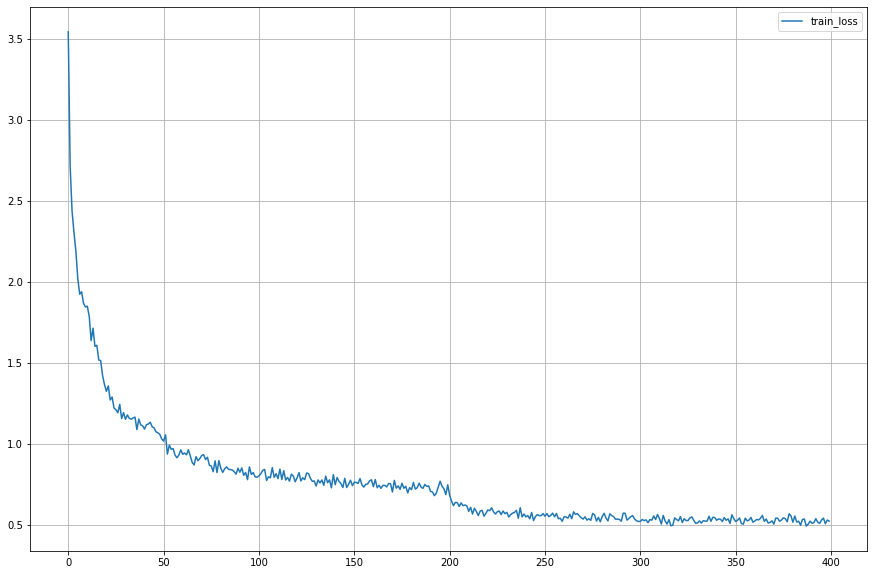

In [19]:
plt.figure(figsize = (15,10))
plt.plot(trn_loss_list, label="train_loss")
plt.legend()
plt.grid('on')
plt.show()

In [16]:
# test acc
# resnet 152, start 0.025 , bs 64 , optimizer SGD momentum 0.9 weight decay 0.00001
with torch.no_grad():
    corr_num = 0
    total_num = 0
    for j, val in enumerate(testLoader):
        val_x, val_label = val
        val_x = val_x.to(device)
        val_label =val_label.to(device)
        val_output = model(val_x)
        model_label = val_output.argmax(dim=1)
        corr = val_label[val_label == model_label].size(0)
        corr_num += corr
        total_num += val_label.size(0)

print("test_acc: {:.2f}".format(corr_num / total_num * 100))

test_acc: 82.24
